In [1]:
import torchvision
from torchinfo import summary
import zipfile
import os
from pathlib import Path

In [2]:
os.chdir('../')
%pwd

'/Users/apple/Documents/Personal/Computer Vision and Deep Learning/card-reader-ml'

In [3]:
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transform = weights.transforms()

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

weights.get_state_dict(True)

OrderedDict([('backbone.body.conv1.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
                  

In [4]:
# model


In [5]:
# summary
summary(model=model, input_size=[1, 3, 640, 480])

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [0, 4]                    --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 1088, 800]         --
├─BackboneWithFPN: 1-2                                  [1, 256, 17, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 34, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 544, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 544, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 544, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 272, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 272, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 136, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [6]:
transform

ObjectDetection()

In [7]:
# obtain dataset
zip_file = Path('artifacts/data_ingestion/dataset2.zip')
with zipfile.ZipFile(zip_file, mode='r') as zip_ref:
  zip_ref.extractall('artifacts/data_ingestion/dataset2')

In [8]:
# dataset class
import glob
import cv2 as cv
from PIL import Image
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader
from xml.etree import ElementTree as et
from matplotlib import pyplot as plt

In [18]:
def get_target(path: Path, classes:list):
  boxes = []
  labels = []
  tree = et.parse(path)
  root = tree.getroot()
  
  # loop through object tag
  for member in root.findall('object'):
    # get the class label index
    labels.append(classes.index(member.find('name').text))
    # xmin
    xmin = int(member.find('bndbox').find('xmin').text)
    # xmax
    xmax = int(member.find('bndbox').find('xmax').text)
    # ymin
    ymin = int(member.find('bndbox').find('ymin').text)
    # ymax
    ymax = int(member.find('bndbox').find('ymax').text)
    
    boxes.append([xmin, ymin, xmax, ymax])
  target = {}
  target['bboxes'] = torch.as_tensor(boxes, dtype=torch.float32)
  target['labels'] = torch.as_tensor(labels, dtype=torch.float32)
  return target

In [19]:
class FasterRCNNCustomDataset(Dataset):
  def __init__(self, root: Path, transform=None) -> None:
    super(FasterRCNNCustomDataset, self).__init__()
    self.root = root
    self.transform = transform
    self.image_paths = list(Path(root).glob('*.jpg'))
    self.label_paths = list(Path(root).glob('*.xml'))
    self.classes = ['background', 'address', 'flag', 'gender', 'heading', 'ic_number', 'level', 'mykad', 'mykad_icon', 'mykid', 'mykid_icon', 'name', 'religion']
  
  def load_img(self, index: int):
    return Image.open(self.image_paths[index])

  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, index: int):
    image = self.load_img(index)
    targets = get_target(self.label_paths[index], self.classes)
    if self.transform:
      return  self.transform(image), targets
    else:
      return image, targets

In [41]:
train_dir = Path('artifacts/data_ingestion/dataset2/train')
test_dir = Path('artifacts/data_ingestion/dataset2/test')
val_dir = Path('artifacts/data_ingestion/dataset2/valid')
# train_set = FasterRCNNCustomDataset(root=train_dir)
test_set = FasterRCNNCustomDataset(root=test_dir, transform=transform)
# val_set = FasterRCNNCustomDataset(root=val_dir)
len(test_set)

7

In [42]:
image, targets = test_set[6]
targets['bboxes'], targets['labels']

(tensor([[ 44., 410., 295., 481.],
         [ 46., 488., 292., 605.],
         [489., 561., 547., 583.],
         [416., 558., 462., 582.],
         [436., 538., 557., 561.],
         [ 48., 173., 250., 219.],
         [ 63.,  70., 370., 173.],
         [374.,  62., 464., 190.],
         [466.,  66., 586., 191.],
         [ 21.,  39., 609., 625.]]),
 tensor([11.,  1.,  3., 12.,  6.,  5.,  4.,  8.,  2.,  7.]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 640, 640])


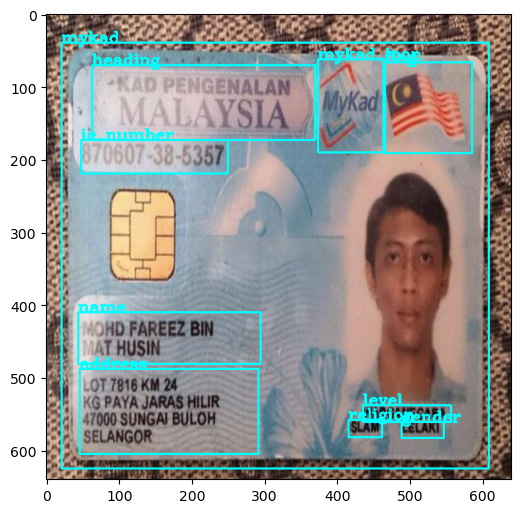

In [58]:
print(image.shape)
np_image = image.numpy().transpose(1,2,0)
for i, box in enumerate(targets['bboxes']):
  name = test_set.classes[int(targets['labels'][i])]
  x1, y1, x2, y2 = box
  x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
  cv.rectangle(np_image, (x1, y1), (x2, y2), color=(0, 255, 255), thickness=2)
  cv.putText(np_image, name, (x1, y1), cv.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 255), 2)

plt.figure(figsize=(6, 10))
plt.imshow(np_image)